# Anomaly Detection Tutorial with Python

---

본 튜토리얼은 Anomaly Detection의 일부분만 다루고 있습니다. 

전체적인 개념을 알고 싶으시다면 고려대학교 강필성 교수님의 [비즈니스 애널리틱스 수업 영상](https://www.youtube.com/watch?v=ECgI1YVQpY8&list=PLetSlH8YjIfWMdw9AuLR5ybkVvGcoG2EW&index=14)을 참고해주세요! 😉

### 🙄 Anomaly Detection이란?

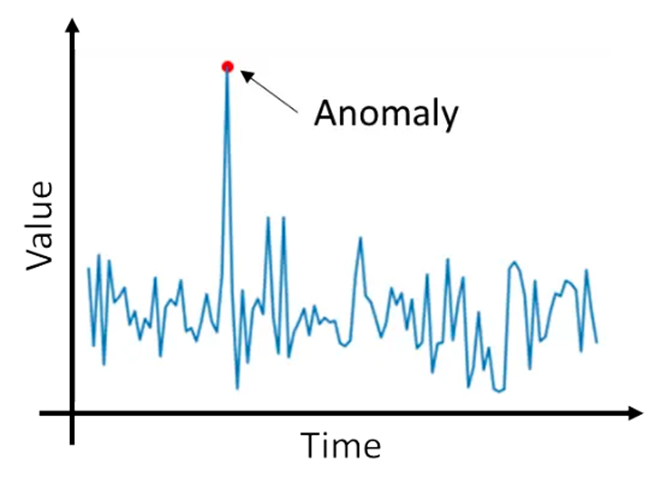

<br>

**Anomaly Detection**이란 예상되거나 기대하는 event가 **아닌 데이터 패턴, 개체** 등을 찾아내는 것입니다! <br>
**이상(abnormal)**이라는 것은 정상(normal)이 아닌 값으로, 이에 대한 정의는 적용 분야 및 문제마다 다르게 정의될 수 있다고 합니다.

## 📚 Anomaly Detection 방법론
Anomaly Detection 방법론은 아래 그림과 같이 여러가지가 존재하는데요! <br>

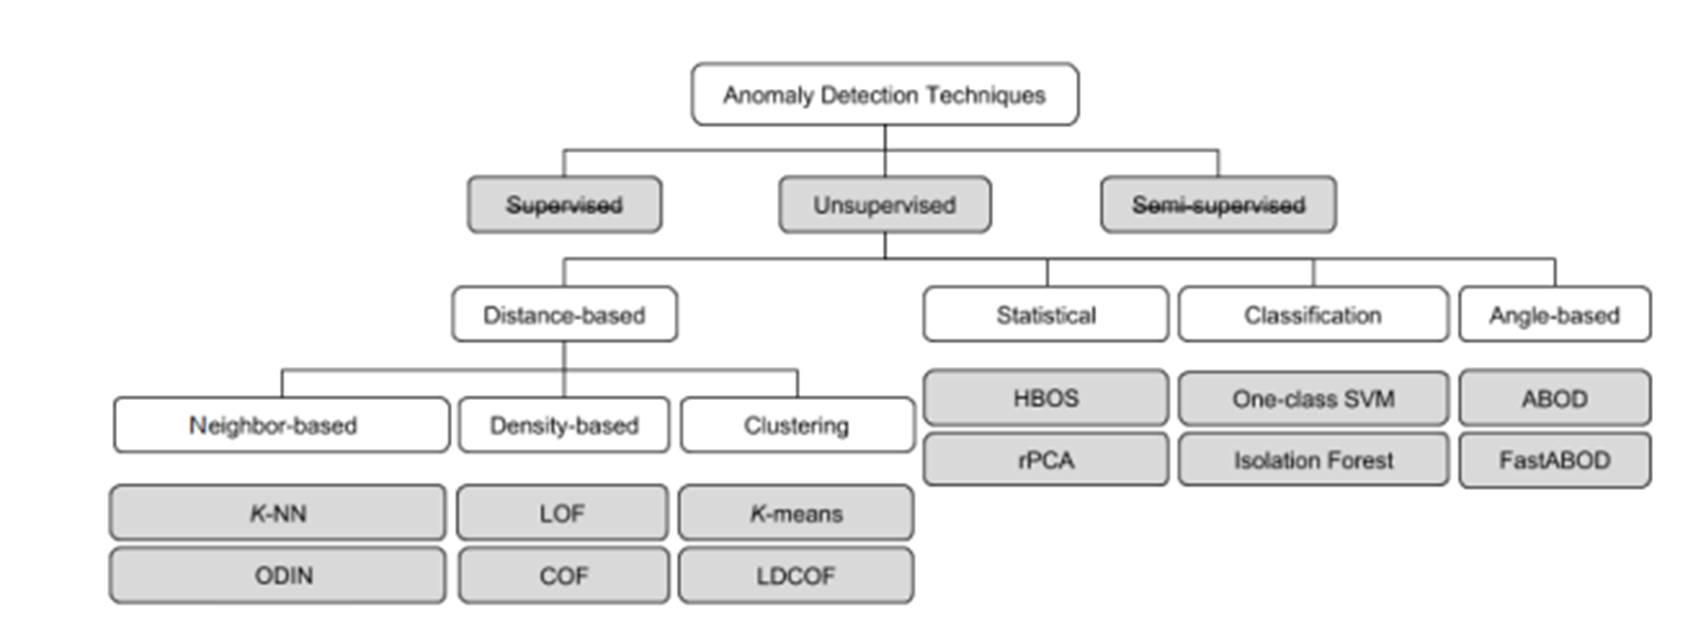  <br>

저와 함께 방법론의 일부를 살펴보도록 하겠습니다 😉<br>
1) Auto-Encoder<br>
2) Isolation Forest<br>
3) Local Outlier Factor<br>
4) One Class SVM<br>
5) Gaussian Density Estimation<br>
6) Mixture of Gaussian<br>


순서는 다음과 같이 진행하겠습니다~

먼저, 필요한 라이브러리를 불러와볼까요? 🙃

In [1]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score,precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold,ParameterGrid

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# manual parameters
RANDOM_SEED = 42
VALIDATE_SIZE = 0.2

import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family = 'NanumGothic') # For Windows
print(plt.rcParams['font.family'])

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42
import random as rn
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

['NanumGothic']


## 💳 데이터셋 :  creditcard.csv
신용카드 거래 데이터를 사용해보겠습니다! 이 데이터는 신용카드의 거래내역에서 사기 여부를 알 수 있는 데이터셋입니다.  <br>
이상탐지에서 기본으로 쓰이는 데이터이기도 하죠!

비식별화된 신용 가드 거래 Feature들이 존재하고 Target은 신용 카드 거래가 정상(= 0)인지 사기(=1)인지를 판단하는 것 입니다. 

데이터를 불러오겠습니다 😉

In [2]:
creditcard = pd.read_csv('creditcard.csv')
creditcard.drop(['Time'], axis=1, inplace=True)
creditcard.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


정상 데이터와 이상 데이터를 분리해보면 다음과 같습니다.

In [31]:
# 클래스 분리
abnormal = creditcard[creditcard['Class'] == 1]
normal = creditcard[creditcard['Class'] == 0 ]

In [32]:
print(f"""Shape of the datasets:
    normal (rows, cols) = {normal.shape}
    abnormal (rows, cols) = {abnormal.shape}""")

Shape of the datasets:
    normal (rows, cols) = (284315, 30)
    abnormal (rows, cols) = (492, 30)


이상 데이터보다 정상 데이터가 훨씬 더 많은 imbalanced data입니다 ! <br>
실제 현실에서도 방대한 양의 신용카드 거래 데이터가 존재하고 사기 거래는 극히 일부일 것 입니다.  <br>
따라서 사람이 수동적으로 라벨링을 하는 것은 매우 어려운 일이겠죠 😣 <br>
그래서 저희는 AI 모델을 학습하여 사기 거래를 자동적으로 빠르게 탐지하려고 합니다.

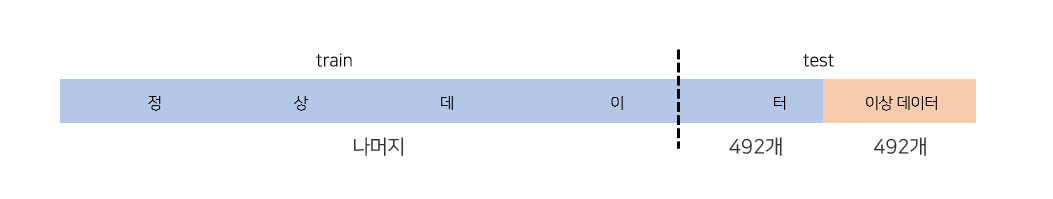
<br> 이상탐지 방법론들은 정상데이터로만 학습을 합니다. <br> 
따라서 위의 그림과 같이 trainset은 정상 데이터만 존재하고 testset은 **이상 데이터**와 **이상데이터 개수(=492개)만큼의 정상 데이터**로 구성됩니다.

In [33]:
# normal data set 랜덤하게 섞기
normal = normal.sample(frac=1,random_state=RANDOM_SEED).reset_index(drop=True)

# train set : 나머지 normal 
X_train = normal.iloc[:-492].drop('Class', axis=1)

# test set : noraml 620개 + abnormal 620
X_test = normal.iloc[-492:].append(abnormal).sample(frac=1)

#  1️⃣ autoencoder 🎥
autoencoder를 학습하기 위해 validation set을 생성하겠습니다.

In [34]:
# train, validation set 분리
X_train1, X_validate1 = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# test set
X_test, y_test = X_test.drop('Class', axis=1).values, X_test.Class.values

In [35]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train1.shape}
    validate (rows, cols) = {X_validate1.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (227058, 29)
    validate (rows, cols) = (56765, 29)
    holdout  (rows, cols) = (984, 29)


## 💡 정규화
정규화는 아래 두 가지의 scaler를 사용해보겠습니다. 과연 어떤 scaler가 성능을 더 높여줄까요?
1. StandardScaler
2. RobustScaler

In [36]:
# scaler 선택 가능

# standard scaler
standard_scaler1 = StandardScaler()
standard_scaler1.fit(X_train1)

X_train_scaled1 = standard_scaler1.transform(X_train1)
X_validate_scaled1 = standard_scaler1.transform(X_validate1)
X_test_scaled1 = standard_scaler1.transform(X_test)

# robust scaler
robust_scaler1 = RobustScaler()
robust_scaler1.fit(X_train1)

X_train_scaled_r1 = robust_scaler1.transform(X_train1)
X_validate_scaled_r1 = robust_scaler1.transform(X_validate1)
X_test_scaled_r1= robust_scaler1.transform(X_test)

## 🙄 Auto-Encoder란?
autoencoder는 encoder와 decoder로 구성되어 있습니다. 

<br>

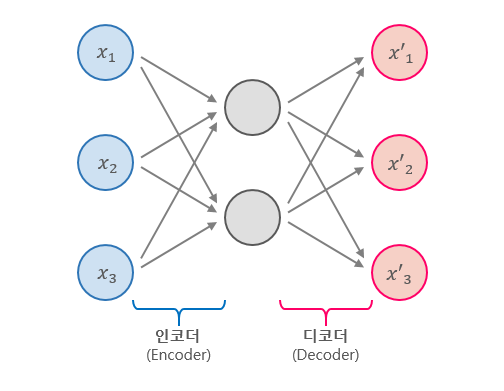

<br>

* 인코더(encoder) : 입력을 내부 표현으로 변환
* 디코더(decoder) : 내부 표현을 출력으로 변환

<br>
오토인코더는 입력을 재구성하기 때문에 출력을 재구성(reconstruction)이라고도 합니다!<br>
이때, 손실함수는 입력과 재구성(출력)의 차이를 가지고 계산을 하죠~ 🙃

아래의 코드를 보면 인코더와 디코더가 대칭적인 구조라는 것을 확인할 수 있습니다 😊

In [37]:
# 파라미터 설정
input_dim = X_train_scaled1.shape[1]
BATCH_SIZE = 512
EPOCHS = 100

autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='ReLU', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(8, activation='ReLU'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='ReLU'),

      
    # reconstruction / decode
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='ReLU'),
    tf.keras.layers.Dense(input_dim, activation='ReLU')
    
])

autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# model overview
autoencoder.summary();

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 29)                870       
                                                                 
 dense_6 (Dense)             (None, 8)                 240       
                                                                 
 batch_normalization_2 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
 batch_normalization_3 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 8)                

In [38]:
# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

# callbacks argument only takes a list
cb = [early_stop]

학습을 해볼까요?

In [39]:
history = autoencoder.fit(
    X_train_scaled1, X_train_scaled1,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_scaled1, X_validate_scaled1)
);

Epoch 1/100
444/444 [==============================] - 5s 9ms/step - loss: 0.9656 - acc: 0.1433 - val_loss: 0.8993 - val_acc: 0.2327
Epoch 2/100
444/444 [==============================] - 3s 8ms/step - loss: 0.8808 - acc: 0.2878 - val_loss: 0.8358 - val_acc: 0.2997
Epoch 3/100
444/444 [==============================] - 3s 8ms/step - loss: 0.8381 - acc: 0.3233 - val_loss: 0.8103 - val_acc: 0.3391
Epoch 4/100
444/444 [==============================] - 3s 8ms/step - loss: 0.8205 - acc: 0.3503 - val_loss: 0.8002 - val_acc: 0.3613
Epoch 5/100
444/444 [==============================] - 3s 7ms/step - loss: 0.8116 - acc: 0.3635 - val_loss: 0.7932 - val_acc: 0.3733
Epoch 6/100
444/444 [==============================] - 3s 8ms/step - loss: 0.8056 - acc: 0.3759 - val_loss: 0.7888 - val_acc: 0.3836
Epoch 7/100
444/444 [==============================] - 4s 8ms/step - loss: 0.8012 - acc: 0.3844 - val_loss: 0.7850 - val_acc: 0.3927
Epoch 8/100
444/444 [==============================] - 4s 8ms/step - 

444/444 [==============================] - 4s 8ms/step - loss: 0.7668 - acc: 0.4546 - val_loss: 0.7553 - val_acc: 0.4602
Epoch 63/100
444/444 [==============================] - 3s 8ms/step - loss: 0.7663 - acc: 0.4554 - val_loss: 0.7557 - val_acc: 0.4533
Epoch 64/100
444/444 [==============================] - 4s 8ms/step - loss: 0.7659 - acc: 0.4569 - val_loss: 0.7556 - val_acc: 0.4548
Epoch 65/100
444/444 [==============================] - 4s 8ms/step - loss: 0.7661 - acc: 0.4558 - val_loss: 0.7557 - val_acc: 0.4577
Epoch 66/100
444/444 [==============================] - 3s 8ms/step - loss: 0.7659 - acc: 0.4556 - val_loss: 0.7549 - val_acc: 0.4579
Epoch 67/100
444/444 [==============================] - 3s 8ms/step - loss: 0.7659 - acc: 0.4562 - val_loss: 0.7553 - val_acc: 0.4570
Epoch 68/100
444/444 [==============================] - 4s 8ms/step - loss: 0.7657 - acc: 0.4575 - val_loss: 0.7550 - val_acc: 0.4545
Epoch 69/100
444/444 [==============================] - 3s 8ms/step - loss:

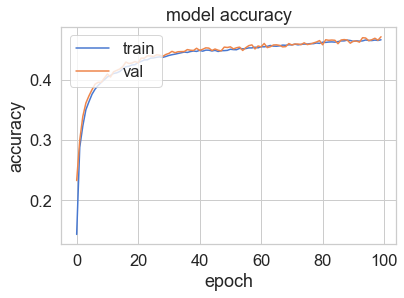

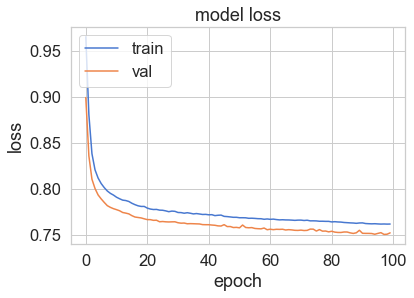

In [40]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

학습시, accurary와 loss의 변화를 보면 안정적으로 학습하고 있네요! 😀

In [41]:
reconstructions = autoencoder.predict(X_test_scaled1)

31/31 [==============================] - 0s 2ms/step


## 📈 Distribution of the Reconstruction Loss
Reconstruction Loss의 분포를 그래프로 나타내봤습니다! 

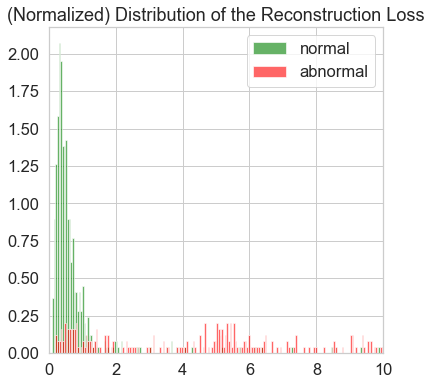

In [43]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal_m, bins=np.arange(min(normal_m),max(normal_m) + 0.05,0.05), density=True, label="normal", alpha=.6, color="green")
ax.hist(abnormal_m,bins=np.arange(min(abnormal_m),max(abnormal_m) + 0.05,0.05), density=True, label="abnormal", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.xlim([0,10])
plt.legend()
plt.show()

확대해서 다시 보면,,

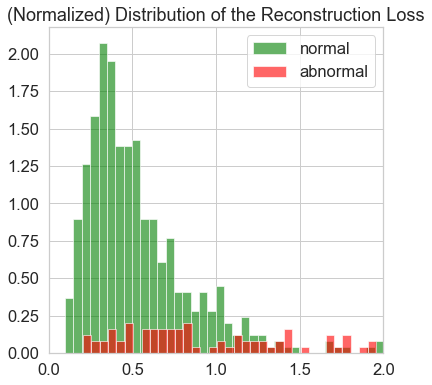

In [42]:
mse = np.mean(np.power(X_test_scaled1 - reconstructions, 2), axis=1)
normal_m = mse[y_test==0]
abnormal_m = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(normal_m, bins=np.arange(min(normal_m),max(normal_m) + 0.05,0.05), density=True, label="normal", alpha=.6, color="green")
ax.hist(abnormal_m,bins=np.arange(min(abnormal_m),max(abnormal_m) + 0.05,0.05), density=True, label="abnormal", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.xlim([0,2.0])
plt.legend()
plt.show()

정상과 이상의 분포가 겹치는 부분이 생각보다 많네요.

여기서 끝이 아니죠!

## 💡 Threshold

Auto-Encoder는 Threshold 설정이 중요합니다. Threshold 값에 따라 성능차이가 클 수 있기 때문이죠! 😮
<br>

저는 다음과 같이 Threshold를 설정했습니다.

1. 정상 데이터의 재구성 오류 분포의 max 값
2. Q3 + 1.5* IQR

In [44]:
# 1. normal 데이터의 재구성 오류 분포의 max값
th1 = normal_m.max()

# 2. IQR
quantile_25 = np.percentile(normal_m, 25)
quantile_75 = np.percentile(normal_m, 75)
IQR_weight = 1.5*(quantile_75 - quantile_25)
th2 = quantile_75 + IQR_weight

th_list = []
th_list.extend([th1,th2])

Threshold에 따라 결과가 어떻게 나올까요? 

              precision    recall  f1-score   support

           0       0.69      1.00      0.82       492
           1       1.00      0.55      0.71       492

    accuracy                           0.78       984
   macro avg       0.85      0.78      0.76       984
weighted avg       0.85      0.78      0.76       984

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       492
           1       0.92      0.88      0.90       492

    accuracy                           0.91       984
   macro avg       0.91      0.91      0.91       984
weighted avg       0.91      0.91      0.91       984



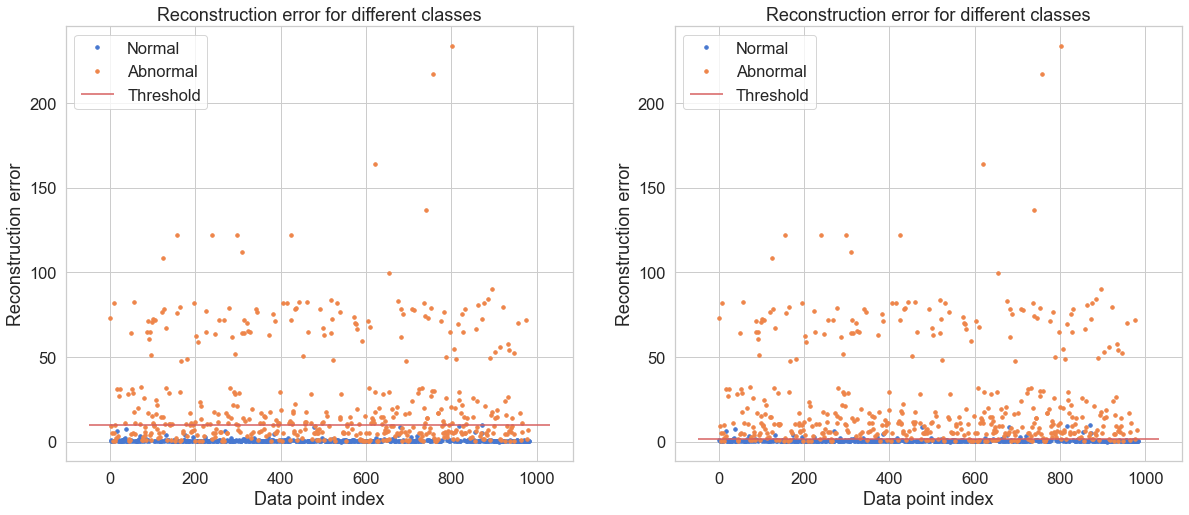

In [45]:
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

plt.figure(figsize=(20, 8))
for i in range(len(th_list)):
    groups = error_df.groupby('true_class')
    
    ax = plt.subplot(1, 2, i+1)
    for name, group in groups:
        plt.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(th_list[i],ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    
    y_pred = [1 if e > th_list[i] else 0 for e in error_df.reconstruction_error.values]
    print(classification_report(error_df.true_class.values,y_pred))

plt.show();

### 😮 결과
역시 지금처럼 정상과 이상의 재구성 오류 분포가 많이 겹칠 때, 정상 데이터의 재구성 오류 분포의 max 값을 threshold로 하면 너무 극단에 있는 값이여서 성능이 좋지 않습니다. 😂 <br>
반면에 IQR를 이용하여 구한 최대 제한선을 Threshold로 한 경우에는 성능이 좋게 나옵니다! 😜

다른 모델의 결과도 한 번 볼까요?

In [52]:
# standard scaler
standard_scaler= StandardScaler()
standard_scaler.fit(X_train)

X_train_scaled = standard_scaler.transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

# robust scaler
robust_scaler = RobustScaler()
robust_scaler.fit(X_train)

X_train_scaled_r = robust_scaler.transform(X_train)
X_test_scaled_r= robust_scaler.transform(X_test)

##  2️⃣ Isolation Forest 🎄

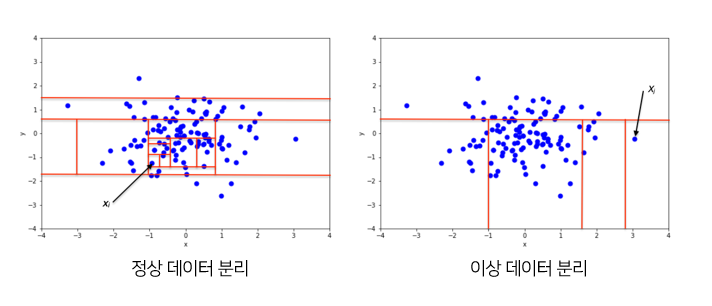 <br>

**Isolation Forest**는 tree 기반의 이상 탐지 방법론입니다!  <br>
랜덤으로 데이터를 split하여 모든 관측치를 고립시키며 구현됩니다.  <br>

각 관측치를 고립(=분리)시키는 것은 이상치가 정상 데이터보다 쉽다는 컨셉을 가지고 있습니다 😊

In [53]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                                       contamination='auto',random_state=RANDOM_SEED, verbose=0)

iforest.fit(X_train)
y_pred = iforest.predict(X_test)

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1


print("Classification Report :")
print(classification_report(y_test,y_pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       492
           1       0.95      0.84      0.89       492

    accuracy                           0.90       984
   macro avg       0.90      0.90      0.89       984
weighted avg       0.90      0.90      0.89       984



### 😮 결과
Auto-Encoder와 비슷한 성능을 보이네요! 계산량이 적다는 장점이 존재하여 실제로도 실행시간도 짧네요 :)

## 3️⃣ Local Outlier Factor 🌘
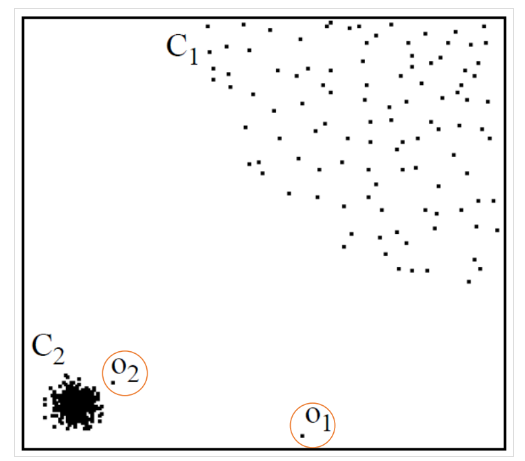 <br>

위 그림을 보면 O1은 이상치라고 바로 말할 수 있지만 O2는 이상치라고 말하기가 애매합니다. 주변에 빽빽하게 밀집해 있는 데이터를 봤을 때는 이상치로 볼 수도 있죠. 

LOF(Local Outlier Factor) 관점에서는 O2도 이상치입니다! 밀집 지역 C2 관점에서 봤을 때는 Dutlier이기 때문이죠.

즉, LOF는 데이터가 가지는 상대적인 밀도를 고려하는 이상 탐지 기법입니다 😏

Standard Scaler와 Robust Scaler를 사용했을 때 결과를 각각 살펴보시죠!

### standard

In [54]:
lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=20, metric='minkowski',
                                              p=2, metric_params=None, contamination='auto',novelty='True')
lof.fit(X_train_scaled)

y_pred = lof.predict(X_test_scaled)

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print("Classification Report :")
print(classification_report(y_test,y_pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.54      0.92      0.68       492
           1       0.74      0.22      0.34       492

    accuracy                           0.57       984
   macro avg       0.64      0.57      0.51       984
weighted avg       0.64      0.57      0.51       984



### robust

In [55]:
lof.fit(X_train_scaled_r)
y_pred = lof.predict(X_test_scaled_r)

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print("Classification Report :")
print(classification_report(y_test,y_pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.61      0.96      0.75       492
           1       0.90      0.39      0.54       492

    accuracy                           0.67       984
   macro avg       0.76      0.67      0.65       984
weighted avg       0.76      0.67      0.65       984



### 😮 결과
LOF는 autoencoder와 isolation forest보다 성능은 안 좋네요. <br>
또한, 두 결과만 놓고 봤을 때는 robust scaler를 사용했을 때 성능이 더 좋습니다. <br>
성능에 대한 신뢰성을 높이기 위해 뒤에서 K-fold Cross Validation 실험도 진행해보겠습니다~~

일단 나머지 모델도 먼저 한 번씩만 실험을 해보겠습니다.

## 4️⃣ One Class SVM 👆

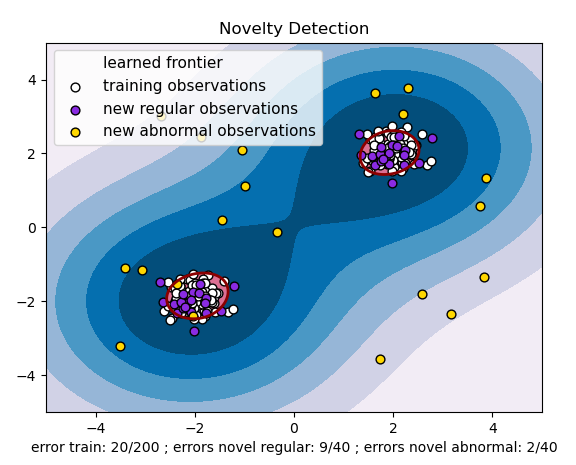 <br>

**OCSVM(One-class SVM)**은 주어진 데이터를 잘 설명할 수 있는 최적의 support vector를 구하고 이 영역 밖의 데이터들은 outlier로 간주하는 이상 탐지 방법론입니다! 

### standard

In [56]:
svm = OneClassSVM(kernel="rbf", nu=0.01)
svm.fit(X_train_scaled)

y_pred = svm.predict(X_test_scaled)

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print("Classification Report :")
print(classification_report(y_test,y_pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       492
           1       0.98      0.83      0.90       492

    accuracy                           0.90       984
   macro avg       0.91      0.90      0.90       984
weighted avg       0.91      0.90      0.90       984



### robust

In [57]:
svm = OneClassSVM(kernel="rbf", nu=0.01)
svm.fit(X_train_scaled_r)

y_pred = svm.predict(X_test_scaled_r)

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print("Classification Report :")
print(classification_report(y_test,y_pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       492
           1       0.97      0.78      0.87       492

    accuracy                           0.88       984
   macro avg       0.89      0.88      0.88       984
weighted avg       0.89      0.88      0.88       984



### 😮 결과
Auto-Encoder와 Isolation Forest의 결과랑 비슷해보이네요. 두 결과만 봤을 떄는 어떠한 스케일링을 사용하면 좋을지 잘 모르겠습니다 ㅎㅎ

# 📊 10-fold Cross Validation

사실 위의 결과들만 봤을 때는 어떤 모델의 성능이 좋은지 잘 모르겠습니다. <br>
그래서 10-fold Cross Validation을 통해 일반화된 성능을 알아보겠습니다! 😙 <br>

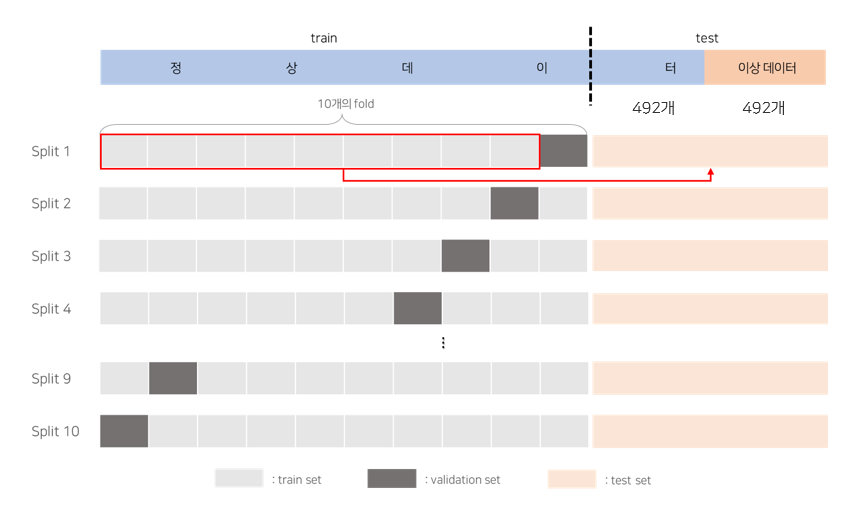 <br>


다음과 같은 순서로 진행됩니다. <br> 
1.  이상데이터(492개)와 정상데이터를 1:1 비율로 하여 test set 생성
2.  Train set으로 10-fold Cross Validation 수행
3. Validation set으로 쓰이는 fold 한 개는 사용하지 않고 나머지 9개의 fold만으로 학습을 진행한 뒤 Test set을 예측함  (isolation forest,  LOF, OCSVM모델은 학습 시 validation set을 사용할 수 없기 때문)
4. 성능지표들(Accuracy, Precision, Recall, F1 score, Integrated Error)의 평균과 표준편차를 계산하여 결과 도출

Auto Encoder, Isolation Forest, Local Outlier Factor, One Class SVM에 대한 10-fold cross validation을 해보겠습니다.

In [70]:
kf = KFold(n_splits = 10)

classifiers = {
    
    "Auto Encoder" : autoencoder ,
    
    
    "Isolation Forest" : IsolationForest(n_estimators=100, max_samples='auto', 
                                       contamination='auto',random_state=RANDOM_SEED, verbose=0),
    
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=20, metric='minkowski',
                                              p=2, metric_params=None, contamination='auto',novelty='True'),
    "Support Vector Machine": OneClassSVM(kernel="rbf", nu=0.01)
    
}

### **Standard Scaler**를 사용한 경우

In [61]:
for i ,(clf_name ,clf) in enumerate(classifiers.items()) :
    
    accuracy_list = []
    precision_list= []
    recall_list = []
    f1score_list = []
    ie_list = []
    n_iter = 0
    
    print(f'=======================모델 : {clf_name} ========================')
    # split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
    for train_index, valid_index in kf.split(X_train):
        n_iter += 1
        print(f'--------------------{n_iter}번째 KFold-------------------')
        train_x, valid_x = X_train.iloc[train_index, :], X_train.iloc[valid_index, :]
        
        # scaler
        standard_scaler.fit(train_x)

        X_train_scaled = standard_scaler.transform(train_x)
        X_validate_scaled = standard_scaler.transform(valid_x)
        X_test_scaled = standard_scaler.transform(X_test)
        
        if clf_name == 'Isolation Forest':
            clf.fit(train_x)
            y_pred = clf.predict(X_test)
            y_pred[y_pred == 1] = 0
            y_pred[y_pred == -1] = 1
            
        elif clf_name == 'Auto Encoder' :
            
            clf.fit(
            X_train_scaled, X_train_scaled,
            shuffle=True,
            epochs=50,
            batch_size=512,
            callbacks=cb,
            verbose = 0,
            validation_data=(X_validate_scaled, X_validate_scaled))

            # 재복원 오차
            reconstructions = autoencoder.predict(X_test_scaled)
            mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)
            error_df = pd.DataFrame({'reconstruction_error': mse,
                                'true_class': y_test})
            y_pred = [1 if e > th2 else 0 for e in error_df.reconstruction_error.values]
        
        else : 
            clf.fit(X_train_scaled)      
            y_pred = clf.predict(X_test_scaled)
            y_pred[y_pred == 1] = 0
            y_pred[y_pred == -1] = 1


        accuracy_list.append(accuracy_score(y_test,y_pred))
        precision_list.append(precision_score(y_test,y_pred))
        recall_list.append(recall_score(y_test,y_pred))
        f1score_list.append(accuracy_score(y_test,y_pred))
        ie_list.append(1-roc_auc_score(y_test,y_pred))
        
        print("Classification Report :",classification_report(y_test,y_pred))
               
    print("10-fold 평균 accuracy :", np.mean(accuracy_list))
    print("10-fold 평균 precision :", np.mean(precision_list))
    print("10-fold 평균 recall :", np.mean(recall_list))
    print("10-fold 평균 f1 score :", np.mean(f1score_list))
    print("10-fold 평균 Integrated Error :", np.mean(ie_list))
    print("------------------------------------------------------")
    print("10-fold 평균 accuracy std :", np.std(accuracy_list))
    print("10-fold 평균 precision std :", np.std(precision_list))
    print("10-fold 평균 recall std :", np.std(recall_list))
    print("10-fold 평균 f1 score std :", np.std(f1score_list))
    print("10-fold 평균 Integrated Error :", np.std(ie_list))
    print("")   
    print("")  


=======================모델 : Auto Encoder ========================
--------------------1번째 KFold-------------------
31/31 [==============================] - 0s 2ms/step
Classification Report :               precision    recall  f1-score   support

           0       0.89      0.93      0.91       492
           1       0.92      0.88      0.90       492

    accuracy                           0.91       984
   macro avg       0.91      0.91      0.91       984
weighted avg       0.91      0.91      0.91       984

--------------------2번째 KFold-------------------
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
31/31 [==============================] - 0s 2ms/step
Classification Report :               precision    recall  f1-score   support

           0       0.89      0.93      0.91       492
           1       0.92      0.88      0.90       492

    accuracy                           0.91       984
   macro avg       0.91      0.91      0.91       984

Classification Report :               precision    recall  f1-score   support

           0       0.86      0.95      0.90       492
           1       0.95      0.84      0.89       492

    accuracy                           0.90       984
   macro avg       0.90      0.90      0.89       984
weighted avg       0.90      0.90      0.89       984

--------------------8번째 KFold-------------------
Classification Report :               precision    recall  f1-score   support

           0       0.84      0.94      0.89       492
           1       0.94      0.82      0.87       492

    accuracy                           0.88       984
   macro avg       0.89      0.88      0.88       984
weighted avg       0.89      0.88      0.88       984

--------------------9번째 KFold-------------------
Classification Report :               precision    recall  f1-score   support

           0       0.85      0.95      0.89       492
           1       0.94      0.83      0.88       492

    accuracy

Classification Report :               precision    recall  f1-score   support

           0       0.85      0.98      0.91       492
           1       0.98      0.83      0.90       492

    accuracy                           0.90       984
   macro avg       0.91      0.90      0.90       984
weighted avg       0.91      0.90      0.90       984

--------------------6번째 KFold-------------------
Classification Report :               precision    recall  f1-score   support

           0       0.85      0.98      0.91       492
           1       0.98      0.83      0.90       492

    accuracy                           0.90       984
   macro avg       0.91      0.90      0.90       984
weighted avg       0.91      0.90      0.90       984

--------------------7번째 KFold-------------------
Classification Report :               precision    recall  f1-score   support

           0       0.85      0.98      0.91       492
           1       0.98      0.83      0.90       492

    accuracy

**Robust Scaler**를 사용한 결과와 합쳐서 정리하면 다음과 같습니다. (Isolation Forest는 tree기반이므로 Scaler를 사용하지 않았습니다😊)<br>

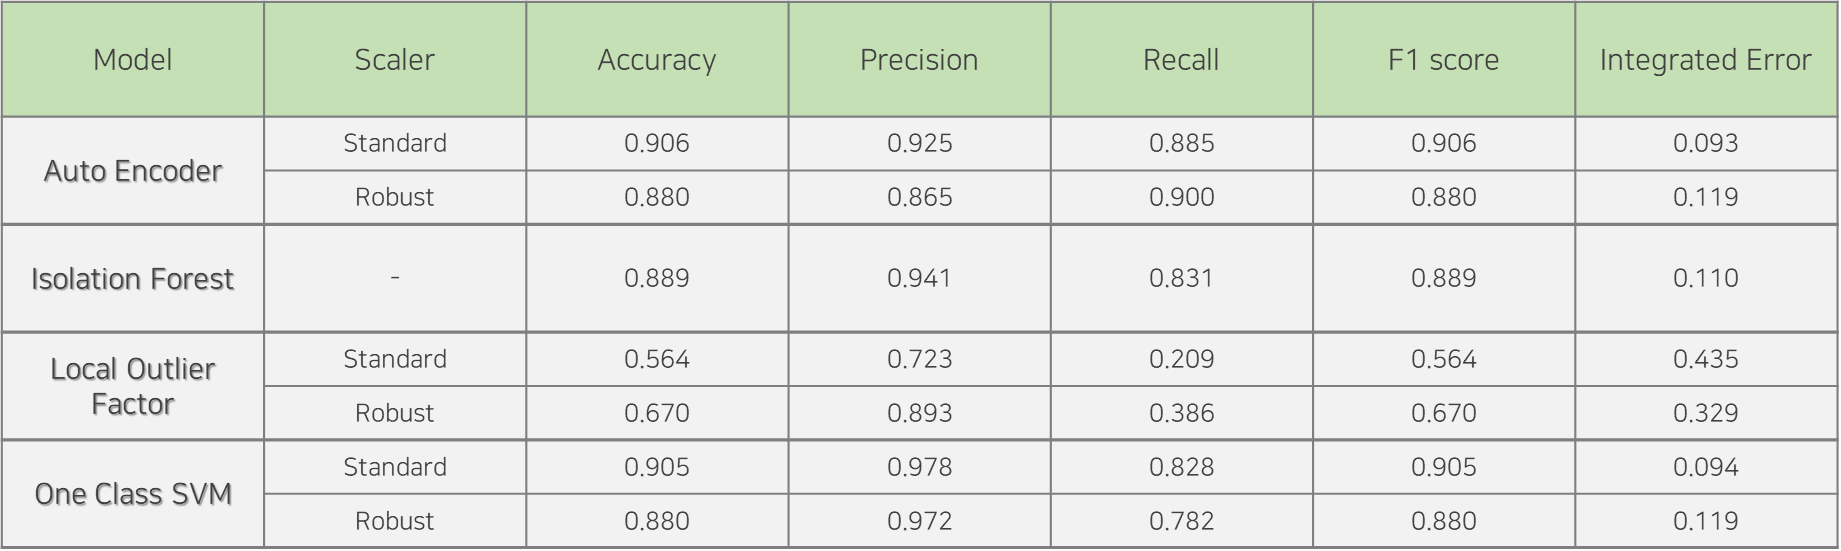

Stadard Scaler를 썼을 때, Auto Endoder와 One Class SVM의 성능이 가장 좋네요. <br>
대부분 비슷한 성능을 보이지만 LOF만 성능이 좋지 않습니다. 

### 💡 왜 그럴까요? 🙄 <br>
t-SNE를 사용하여 데이터 시각화를 해봤습니다! <br>

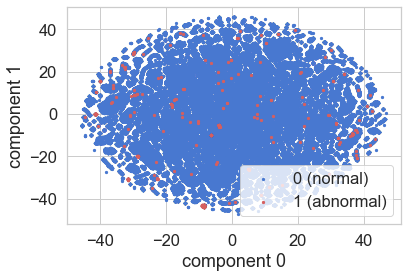

In [78]:
tsne_np = TSNE(n_components =2).fit_transform(creditcard)

# numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(data=tsne_np, columns = ['component 0', 'component 1'])

# 시각화
# class target 정보 불러오기 
tsne_df['target'] = creditcard['Class']

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]

# target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'b', label = '0 (normal)',s=5)
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'r', label = '1 (abnormal)',s=5)

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

오호.. t-SNE를 사용하면 높은 차원 공간에서 비슷한 데이터 구조는 낮은 차원 공간에서 가깝게 대응하고, 비슷하지 않은 데이터 구조는 멀리 떨어져서 시각화가 됩니다. 하지만 그림을 보면 정상데이터와 이상데이터의 밀도 차이가 많이 나지 않는 것 같네요.
<br> 
그래서 밀도 기반 알고리즘인 LOF의 성능이 떨어지지 않았나라는 생각이 듭니다. 😮

## Density-based Anomaly Detection
추가로 Density-based Anomaly Detection 방법론을 사용해보겠습니다.😁 <br>

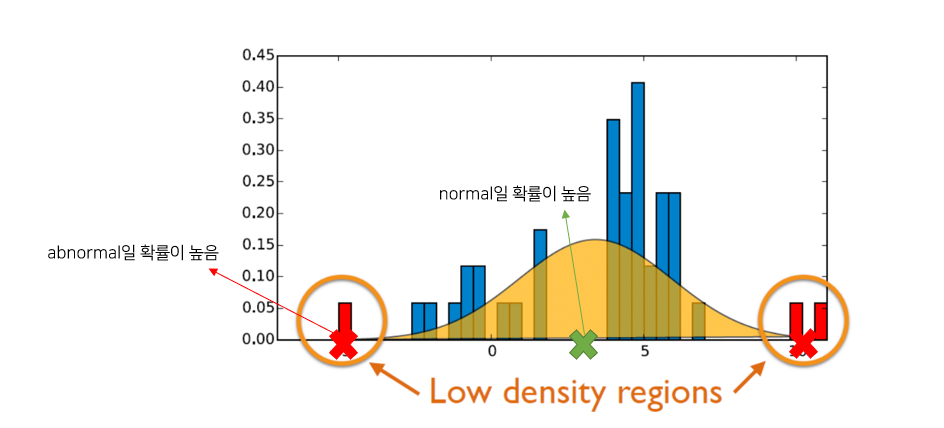 <br>


**Density-based Anomaly Detection**이란 정상 데이터의 분포를 추정하고 새로운 데이터가 들어왔을 떄, 생성될 확률이 낮을 경우 이상치로 판단하는 방법입니다. 


## 5️⃣ Gaussian Density Estimation 🗻  , 6️⃣ Mixture of Gaussian 🌋🌋🌋

`Gaussian Density Estimation`에서의 가정은 **각 데이터 샘플이 하나의 가우시안(정규) 분포로부터 생성된다**인데요.

학습시, 주어진 정상 데이터들을 통해 가우시안 분포의 평균 벡터와 공분산 행렬을 추정하고

테스트시, 새로운 데이터에 대하여 생성 확률을 구하고 이 확률이 낮을수록 이상치에 가까운 것으로 판정합니다. 

<br>
<br>

**장점**
1) 적절한 기준치를 분포로부터 정할 수 있다.
2) 각 변수의 측정 단위에 영향을 받지 않는다.  =  데이터를 스케일링하지 않아도 된다.
<br>

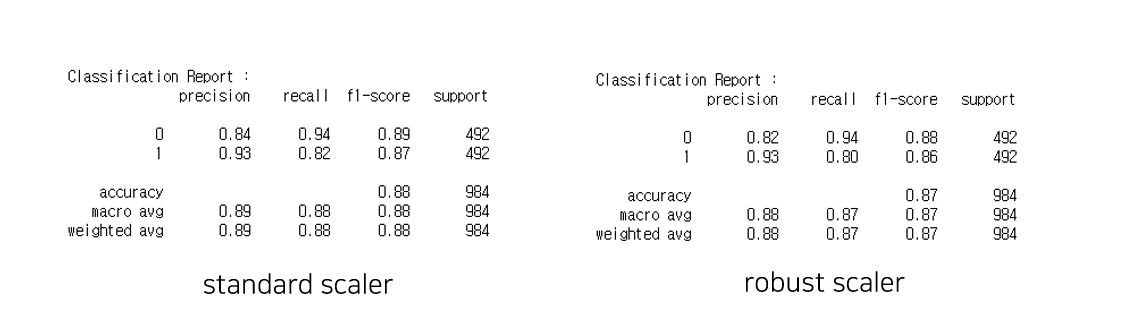
확인해보니 스케일링에 따라 성능 차이가 미미하네요! 따라서 스케일링은 진행하지 않겠습니다 😊

하지만 모든 data가 하나의 gaussian 분포로부터 추정된다는 것은 현실적으로 어렵습니다. 🤣

<br>
<br>

그래서 이를 보완한 모델이 `Mixture of Gaussian`입니다. <br>
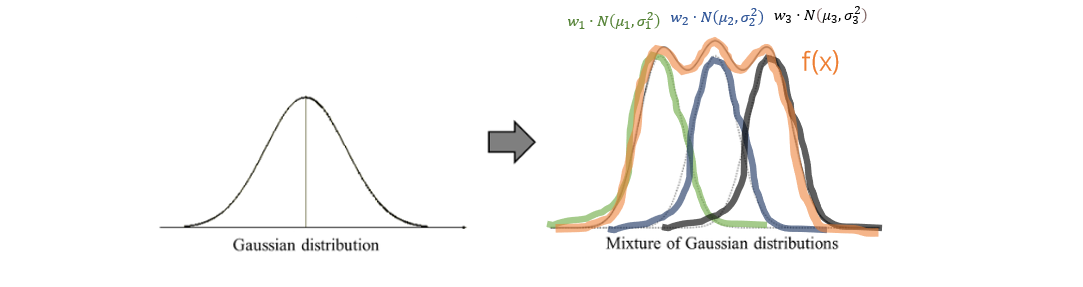 <br>

각 데이터 샘플이 여러 Gaussian 분포의 혼합으로 생성된다고 가정합니다. <br>
즉, 가우시안 분포들의 선형 결합으로 전체 데이터의 분포를 표현하는 것이죠! 

<br>

하나의 Gaussian 분포에 비해, **Bias가 적은 결과**를 산출하지만 MoG 분포 추정을 위해서는 더 많은 학습 데이터가 필요하다고 합니다! 

결과를 한 번 볼까요? 😏

In [80]:
g_classifiers = {
    
    "Gaussian Density" : EllipticEnvelope() ,
    
    
    "Mixture of Gaussian" : GaussianMixture(n_components=3, n_init=4, random_state=42)   
}

In [81]:
for i ,(clf_name ,clf) in enumerate(g_classifiers.items()) :
    
    accuracy_list = []
    precision_list= []
    recall_list = []
    f1score_list = []
    ie_list = []
    n_iter = 0
    
    print(f'=======================모델 : {clf_name} ========================')
    # split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
    for train_index, valid_index in kf.split(X_train):
        n_iter += 1
        print(f'--------------------{n_iter}번째 KFold-------------------')
        train_x, valid_x = X_train.iloc[train_index, :], X_train.iloc[valid_index, :]      
        
        clf.fit(train_x)

        # threshold 설정
        densities = clf.score_samples(train_x)
        density_threshold = np.percentile(densities, 4) 

        y_scores=clf.score_samples(X_test)
        y_pred =y_scores< density_threshold

        accuracy_list.append(accuracy_score(y_test,y_pred))
        precision_list.append(precision_score(y_test,y_pred))
        recall_list.append(recall_score(y_test,y_pred))
        f1score_list.append(accuracy_score(y_test,y_pred))
        ie_list.append(1-roc_auc_score(y_test,y_pred))
        
                   
    print("10-fold 평균 accuracy :", np.mean(accuracy_list))
    print("10-fold 평균 precision :", np.mean(precision_list))
    print("10-fold 평균 recall :", np.mean(recall_list))
    print("10-fold 평균 f1 score :", np.mean(f1score_list))
    print("10-fold 평균 Integrated Error :", np.mean(ie_list))
    print("------------------------------------------------------")
    print("10-fold 평균 accuracy std :", np.std(accuracy_list))
    print("10-fold 평균 precision std :", np.std(precision_list))
    print("10-fold 평균 recall std :", np.std(recall_list))
    print("10-fold 평균 f1 score std :", np.std(f1score_list))
    print("10-fold 평균 Integrated Error :", np.std(ie_list))
    print("")   
    print("")  

=======================모델 : Gaussian Density ========================
--------------------1번째 KFold-------------------
--------------------2번째 KFold-------------------
--------------------3번째 KFold-------------------
--------------------4번째 KFold-------------------
--------------------5번째 KFold-------------------
--------------------6번째 KFold-------------------
--------------------7번째 KFold-------------------
--------------------8번째 KFold-------------------
--------------------9번째 KFold-------------------
--------------------10번째 KFold-------------------
10-fold 평균 accuracy : 0.7778455284552845
10-fold 평균 precision : 0.9112785552833762
10-fold 평균 recall : 0.6105691056910569
10-fold 평균 f1 score : 0.7778455284552845
10-fold 평균 Integrated Error : 0.22215447154471546
------------------------------------------------------
10-fold 평균 accuracy std : 0.09041083586159576
10-fold 평균 precision std : 0.024438090412926307
10-fold 평균 recall std : 0.18248637126011297
10-fold 평균 f1 score std : 0.09041

전체 결과를 확인해보겠습니다!

## 😮 결과

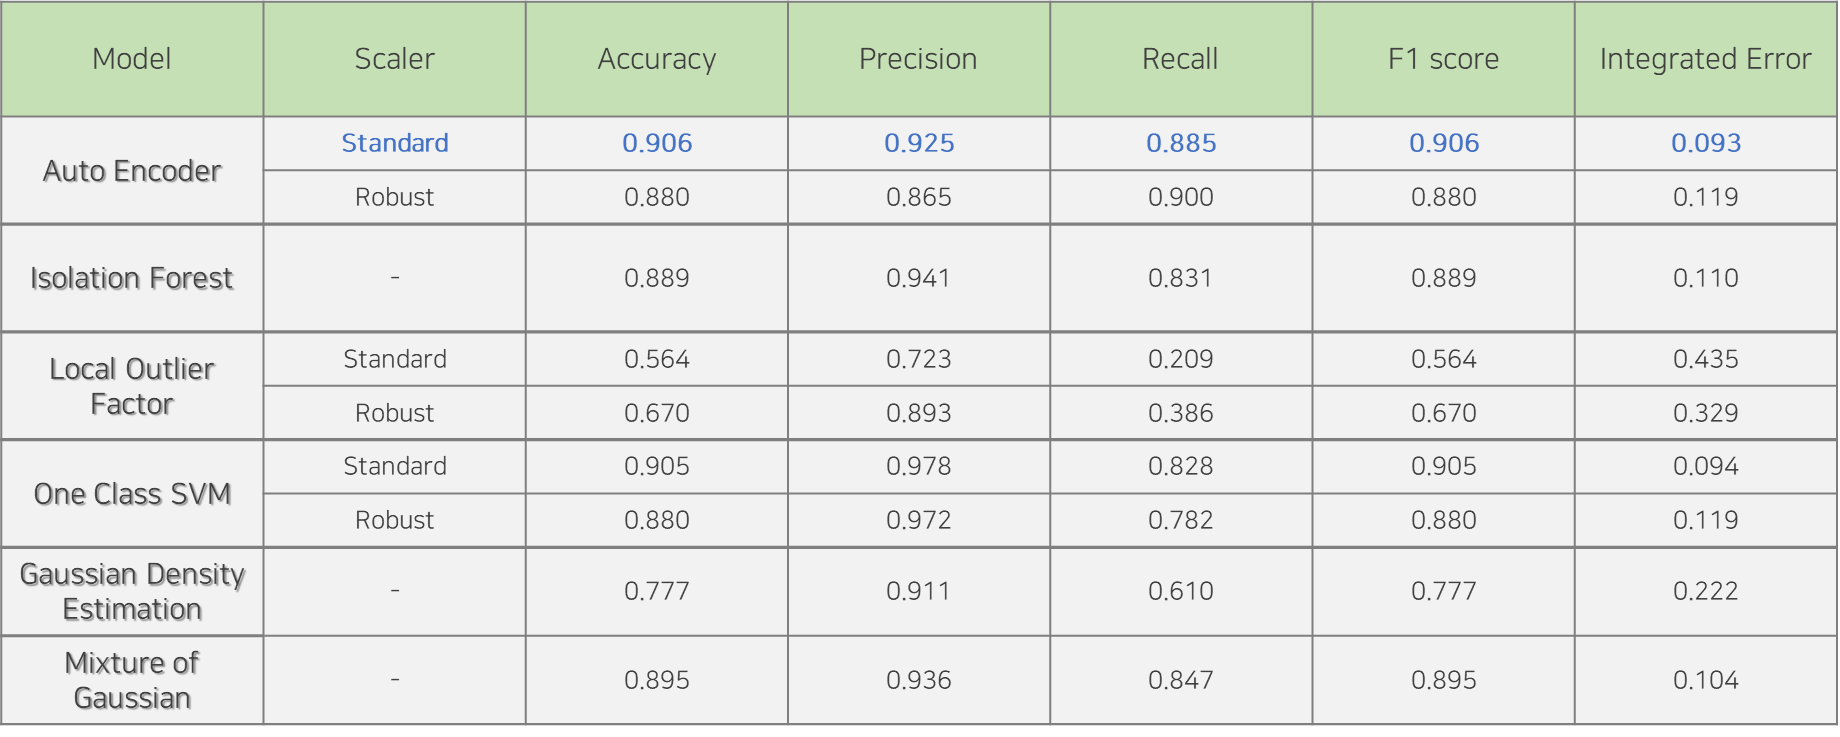 <br>

Isolation Forest와 비슷한 성능 결과를 보여주네요. <br>
또한, Gaussian Density Estimation보다 Mixture of Gaussian의 성능이 더 좋습니다. <br>
Gaussian Density Estimation의 단점을 잘 보완해줬나봅니다 🙃


## 📚 [추가 실험 ] Binary Classification (Supervised Learning)

사실 저희에게는 Y값이 모두 존재하기 때문에 **Supervised Learning** 방법을 적용 할 수도 있습니다. <br>
1) raw data에 적용<br>
2) Data imbalance 문제를 해결하기 위해 **Undersampling** <br>

두 가지 경우에 Classification 모델을 적용해보도록 하죠! <br>

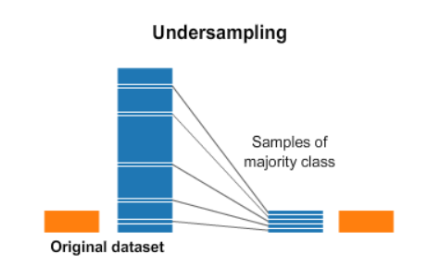
 <br>
과연 정상 데이터로만 학습했던 **이상탐지 알고리즘(Semi-Unsupervised Learning)과 성능 차이**가 있을까요?


1) Logistic Regression <br>
2) Support Vector Machine <br>
3) Random Forest <br>

다음 세가지의 모델 결과를 보도록 하죠!

Undersampling 기법 중 다수의 클래스에 속해 있는 관측치를 무작위로 샘플링하는 **Random Undersampling**을 사용하겠습니다. <br>
샘플링 마다 모델의 성능이 달라지긴 하지만 의외로 괜찮게 사용되는 경우가 있다고 하네요.

In [10]:
from imblearn.under_sampling import *
X_resampled_r, y_resampled_r = RandomUnderSampler(random_state=0).fit_resample(creditcard.drop('Class', axis=1).values, creditcard.Class.values)

In [11]:
X = pd.DataFrame(X_resampled_r)
y = pd.Series(y_resampled_r)
resample_df = pd.concat([X,y],axis =1)
resample_df.columns = creditcard.columns
resample_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2.049094,0.186189,-1.707198,0.530768,0.160589,-1.448570,0.239310,-0.353611,0.634425,-0.471390,...,0.197782,0.741141,-0.009744,-0.085057,0.228384,-0.097292,-0.001028,-0.032390,2.99,0
1,2.125540,-0.030714,-1.527653,0.121046,0.543172,-0.347988,0.157221,-0.229126,0.477999,0.046959,...,-0.336497,-0.838932,0.275173,0.049145,-0.156765,0.205919,-0.072321,-0.059009,1.98,0
2,-4.155859,-5.705748,0.274699,-0.993262,-6.059393,5.210848,5.811316,0.367888,1.750710,-4.171672,...,1.371671,1.195815,4.188762,-1.091077,1.033044,0.224493,-0.486741,0.194275,1937.66,0
3,-0.566420,-0.579576,0.823503,-1.451240,-0.583587,0.206381,1.601392,-0.370446,-1.910354,0.252497,...,-0.065082,-0.761357,0.641524,-0.568974,-0.053164,-0.690995,-0.228630,-0.157254,320.05,0
4,0.060858,-0.261762,-1.699493,-1.202327,3.699527,3.196249,0.437208,0.421541,0.492435,-0.455964,...,0.008303,0.534602,0.089602,0.667918,0.017798,0.611584,-0.469946,-0.514370,11.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
980,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
981,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
982,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


이상 데이터 개수와 맞게 정상 데이터 개수가 줄었네요!

스케일링은 standar scaler를 사용하겠습니다~~

In [3]:
standard_scaler= StandardScaler()

1) raw data

In [4]:
# raw data
x_train, x_test, y_train, y_test = train_test_split(creditcard.drop('Class', axis=1).values, creditcard.Class.values, test_size=0.2, stratify = creditcard.Class,random_state=RANDOM_SEED)

# scaler
standard_scaler.fit(x_train)

x_train = standard_scaler.transform(x_train)
x_test = standard_scaler.transform(x_test)

In [5]:
binary_classifiers = {  
    
    "Logistic Regression" : LogisticRegression(random_state=RANDOM_SEED),
    
    "Support Vector Machine" : SVC(kernel='rbf', C=100,random_state=RANDOM_SEED),
    
    "Random Forest":  RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    
}

In [6]:
for i ,(clf_name ,clf) in enumerate(binary_classifiers.items()) :
    
    print(f'=======================모델 : {clf_name} ========================')
  
    clf.fit(x_train,y_train)

    # 예측하기
    prediction = clf.predict(x_test)
               
    print("accuracy :", accuracy_score(y_test,prediction))
    print("precision :", precision_score(y_test,prediction))
    print("recall :", recall_score(y_test,prediction))
    print("f1 score :", f1_score(y_test,prediction))
    print("Integrated Error :", 1-roc_auc_score(y_test,prediction))
    
    print('Confusion Matrix : ', confusion_matrix(y_test,prediction))
    


=======================모델 : Logistic Regression ========================
accuracy : 0.9991748885221726
precision : 0.8311688311688312
recall : 0.6530612244897959
f1 score : 0.7314285714285713
Integrated Error : 0.17358369557727427
Confusion Matrix :  [[56851    13]
 [   34    64]]
=======================모델 : Support Vector Machine ========================
accuracy : 0.9993679997191109
precision : 0.8875
recall : 0.7244897959183674
f1 score : 0.797752808988764
Integrated Error : 0.1378342382253971
Confusion Matrix :  [[56855     9]
 [   27    71]]
=======================모델 : Random Forest ========================
accuracy : 0.9996137776061234
precision : 0.9418604651162791
recall : 0.826530612244898
f1 score : 0.8804347826086957
Integrated Error : 0.08677865842454036
Confusion Matrix :  [[56859     5]
 [   17    81]]


정상데이터가 이상데이터보다 훨씬 많은 imbalance data이기 때문에 accurary는 높지만 recall이 낮습니다. <br>
**실제 이상을 이상으로 예측을 잘 하지 못하는**거죠! 그렇다면 undersampling을 하면 결과가 어떻게 될까요?


2) Undersampling data

In [12]:
# resampling data
x_train2, x_test2, y_train2, y_test2 = train_test_split(resample_df.drop('Class', axis=1).values, resample_df.Class.values, test_size=0.2, stratify = y, random_state=RANDOM_SEED)

# scaler
standard_scaler.fit(x_train2)

x_train2 = standard_scaler.transform(x_train2)
x_test2 = standard_scaler.transform(x_test2)

In [13]:
for i ,(clf_name ,clf) in enumerate(binary_classifiers.items()) :
    
    print(f'=======================모델 : {clf_name} ========================')
  
    clf.fit(x_train2,y_train2)

    # 예측하기
    prediction = clf.predict(x_test2)
               
    print("accuracy :", accuracy_score(y_test2,prediction))
    print("precision :", precision_score(y_test2,prediction))
    print("recall :", recall_score(y_test2,prediction))
    print("f1 score :", f1_score(y_test2,prediction))
    print("Integrated Error :", 1-roc_auc_score(y_test2,prediction))
    
    print('Confusion Matrix : ', confusion_matrix(y_test2,prediction))
    


=======================모델 : Logistic Regression ========================
accuracy : 0.9543147208121827
precision : 0.9587628865979382
recall : 0.9489795918367347
f1 score : 0.9538461538461539
Integrated Error : 0.04571222428365285
Confusion Matrix :  [[95  4]
 [ 5 93]]
=======================모델 : Support Vector Machine ========================
accuracy : 0.9593908629441624
precision : 0.96875
recall : 0.9489795918367347
f1 score : 0.9587628865979382
Integrated Error : 0.040661719233147764
Confusion Matrix :  [[96  3]
 [ 5 93]]
=======================모델 : Random Forest ========================
accuracy : 0.9543147208121827
precision : 0.978494623655914
recall : 0.9285714285714286
f1 score : 0.9528795811518325
Integrated Error : 0.045815295815295864
Confusion Matrix :  [[97  2]
 [ 7 91]]


unsampling시, 성능이 향상되는군요!<br>
결과는 다음과 같습니다! 😉

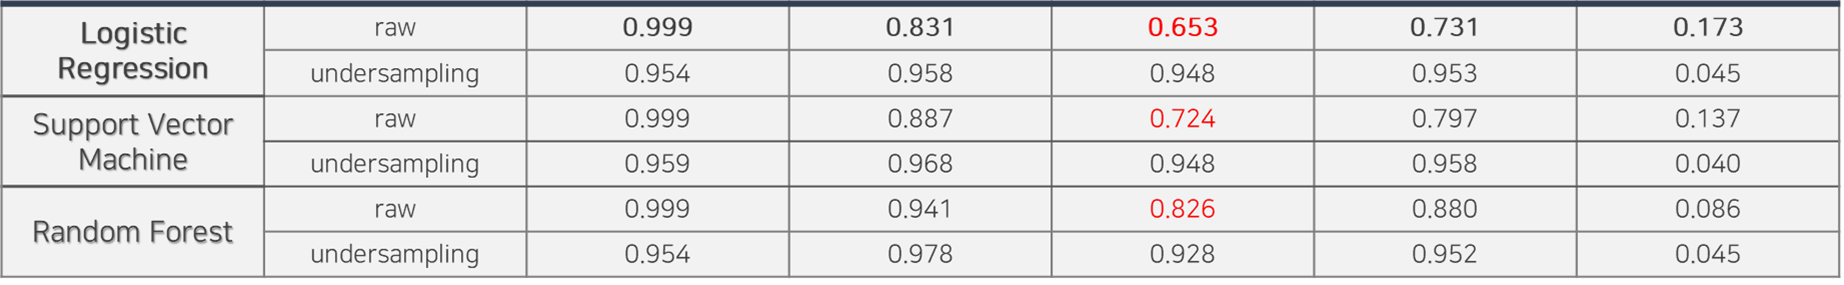

----------------------------------------------

## 😉 결론
**AutoEncoder와 One Class SVM**의 성능이 가장 좋았고, Isolation Forest와 Mixture of gaussian의 성능도 괜찮게 나왔습니다.<br>
하지만, Local Outlier Factor의 경우, 밀도 기반으로 이상 탐지를 하다보니 해당 데이터와 맞지 않는 것 같았습니다.<br>
학습 시간도 다른 알고리즘에 비해 오래 걸렸습니다 😂
<br>
AutoEncoder와 One Class SVM도 성능은 좋지만 Threshold에 따라 성능이 달라지거나 파라미터에 따라 성능 차이가 난다는 특징이 있기 때문에
robust하면서 좋은 성능을 내는 모델은 **isolation forest**인 것 같습니다! 😀

또한, binary classification 모델을 사용하면 정상 데이터의 수가 워낙 많다보니 accuracy는 높지만 **실제 이상을 잘못 예측**하는 경우가 많았습니다. 이때, Undersamping을 통해 imbalance 문제를 해결하는 것도 좋지만 이 경우에는 **정보 손실**이 일어나기 때문에 이상탐지 방법론을 사용하는 것이 낫겠죠! ㅎㅎ

### Reference
- https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders
- https://www.kaggle.com/code/victorambonati/unsupervised-anomaly-detection
- https://gaussian37.github.io/ml-concept-andrewng-anomalydetection/
- https://github.com/rhasanbd/Gaussian-Mixture-Model-Powerful-Tool-for-Clustering-Anomaly-Detection-Data-Generation/blob/master/Clustering-GMM-7-Anomaly%20Detection.ipynb
- https://excelsior-cjh.tistory.com/187
- https://en.wikipedia.org/wiki/Isolation_forest#/media/File:Isolating_an_Anomalous_Point.png
- https://velog.io/@vvakki_/Isolation-Forest-%EB%AF%B8%EC%99%84%EC%84%B1
- https://jayhey.github.io/novelty%20detection/2017/11/10/Novelty_detection_LOF/
- https://ssung-22.tistory.com/31
- https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html
- https://hwi-doc.tistory.com/entry/%EC%96%B8%EB%8D%94-%EC%83%98%ED%94%8C%EB%A7%81Undersampling%EA%B3%BC-%EC%98%A4%EB%B2%84-%EC%83%98%ED%94%8C%EB%A7%81Oversampling
- https://techblog-history-younghunjo1.tistory.com/123